# Airline Passengers Forecasting Using Time Series Methods

📌 We used the following methods for airline passenger forecasting:

**SES**: Single Exponential Smoothing

**DES**: Double Exponential Smoothing

**TES**: Triple Exponential Smoothing

**ARIMA**: Autoregressive Integrated Moving Average

**SARIMA**: Seasonal Autoregressive Integrated Moving Average



# Business Problem

📌 In this section, we estimate the number of passengers in the coming years by examining the number of passengers in the past years.

# Dataset Story

📌 This dataset contains how many passengers traveled monthly from 1949 to 1960.

**Month**: the date in the month is a variable.

**Passengers**: estimates the number of passengers per month.

# Import Necessary Libraries

In [ ]:
import itertools
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/AirPassengers.csv", index_col='Month', parse_dates=True)
df.rename({'#Passengers': 'Passengers'}, axis=1, inplace=True)
df.index.freq = 'MS'
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# General Information About to the Dataset

In [ ]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

######################### Head #########################
            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
######################### Tail #########################
            Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432
######################### Shape #########################
(144, 1)
######################### Types #########################
Passengers    int64
dtype: object
######################### NA #########################
Passengers    0
dtype: int64
######################### Qurtiles #########################
              count     mean      std      min       0%       5%      50%      95%      99%     100%      max
Passengers 144.0000 280.2986 119.9663 104.0000 104.0000 121.6000 265.5000 488.1500 585.7900 622.0000 622.0000


# Visualizing the Time Series Simply

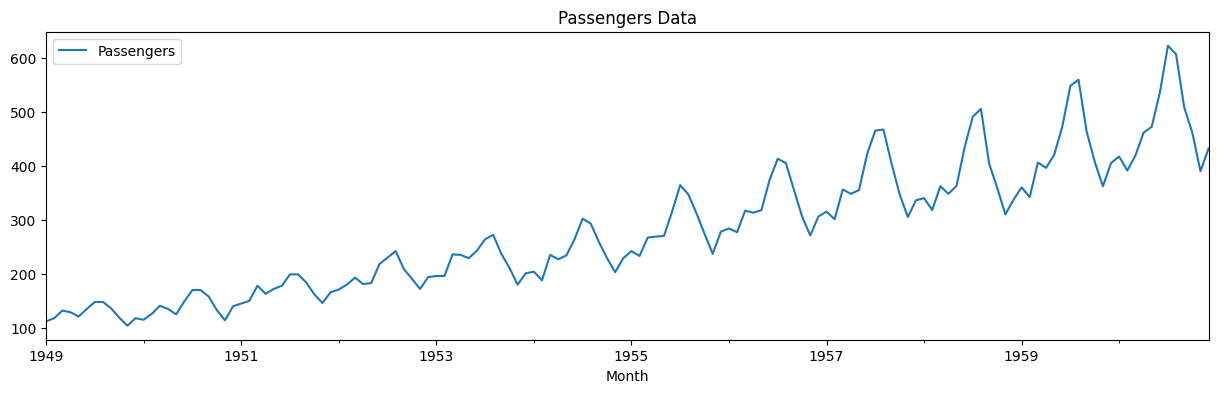

In [ ]:
df[['Passengers']].plot(figsize=(15,4), title='Passengers Data')
plt.show()

# Splitting the Dataset

In [ ]:
# Using Holdut Method ===> Train: 120 Month and Test: 24 Month
train = df[:120]
test = df[120:]
print((len(train), len(test)))

(120, 24)


# Time Series Structural Analysis

In [ ]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

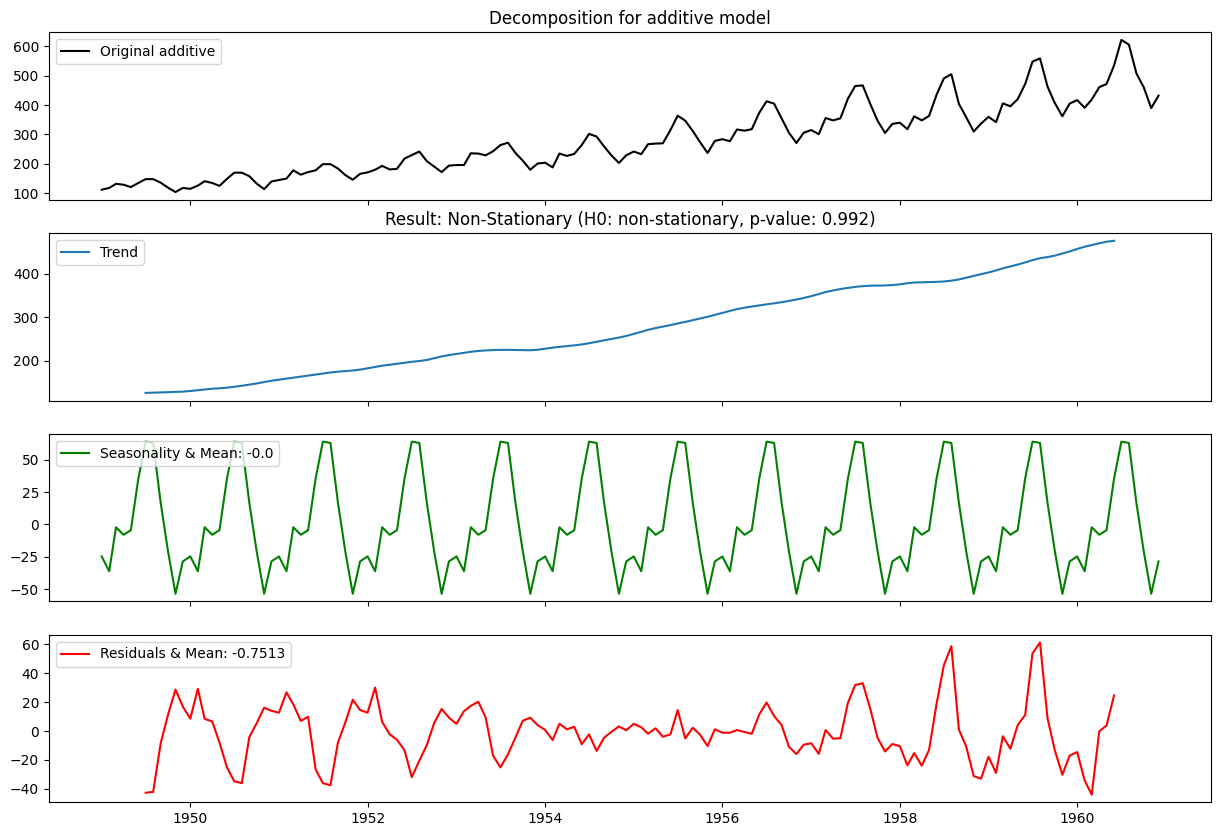

In [ ]:
ts_decompose(df)

# SES: Single Exponential Smoothing

📌 Single Exponential Smoothing, SES for short, also called Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality.

📌 It requires a single parameter, called alpha (a), also called the smoothing factor or smoothing coefficient.

📌 This parameter controls the rate at which the influence of the observations at prior time steps decay exponentially. Alpha is often set to a value between 0 and 1. Large values mean that the model pays attention mainly to the most recent past observations, whereas smaller values mean more of the history is taken into account when making a prediction.

In [ ]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train["Passengers"].plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test["Passengers"].plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [ ]:
def ses_optimizer(train, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [ ]:
def ses_model_tuning(train , test, step, title="Model Tuning - Single Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.1)
  best_alpha, best_mae = ses_optimizer(train, alphas, step=step)
  final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

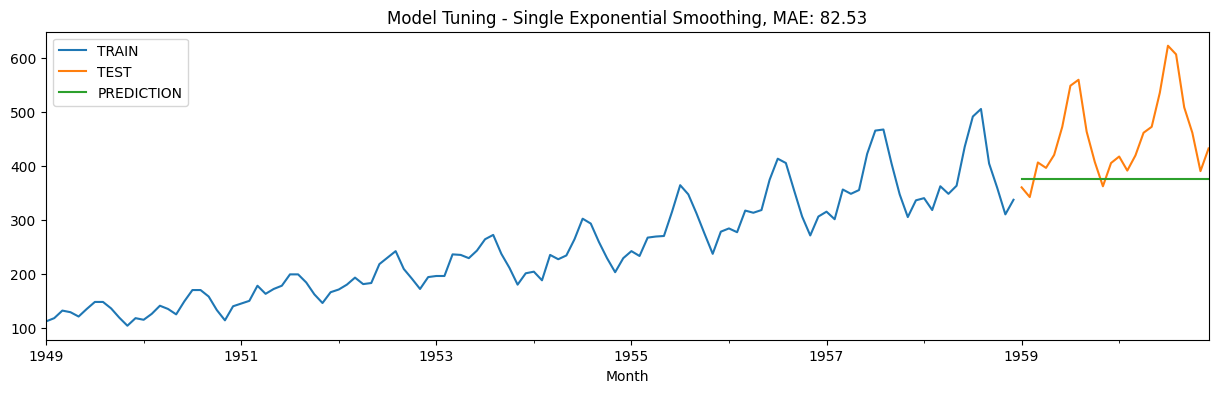

In [ ]:
ses_model_tuning(train, test, step=24)

# DES: Double Exponential Smoothing

📌 Double Exponential Smoothing is an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.

📌 In addition to the alpha parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend called beta (b).

📌 The method supports trends that change in different ways: an additive and a multiplicative, depending on whether the trend is linear or exponential respectively.

📌 Double Exponential Smoothing with an additive trend is classically referred to as Holt’s linear trend model, named for the developer of the method Charles Holt.

  * **Additive Trend**: Double Exponential Smoothing with a linear trend.
  * **Multiplicative Trend**: Double Exponential Smoothing with an exponential trend.

📌 For longer range (multi-step) forecasts, the trend may continue on unrealistically. As such, it can be useful to dampen the trend over time.

In [ ]:
def des_optimizer(train, alphas, betas, trend, step):

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae

In [ ]:
def des_model_tuning(train , test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.10)
  betas = np.arange(0.01, 1, 0.10)
  best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, trend=trend, step=step)
  final_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

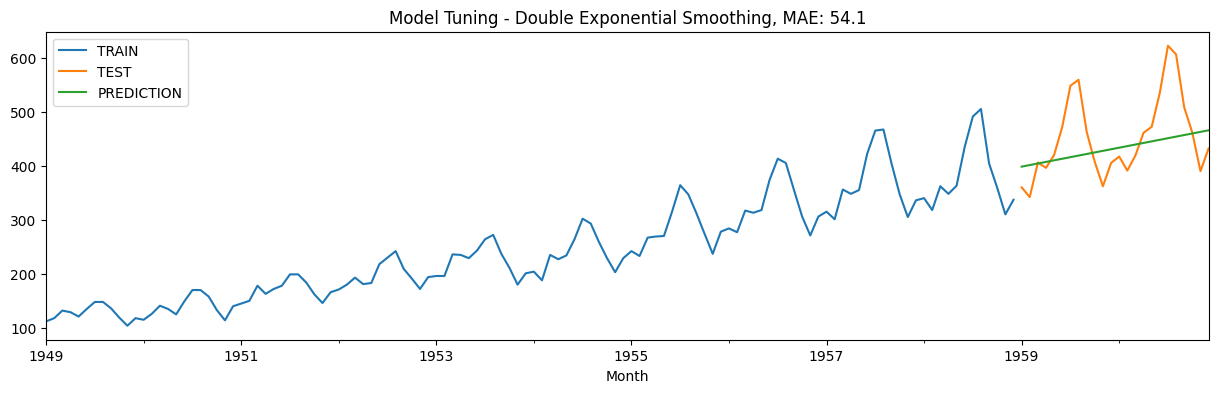

In [ ]:
des_model_tuning(train, test, step=24, trend='add')

# TES: Triple Exponential Smoothing

📌 Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.

📌 This method is sometimes called Holt-Winters Exponential Smoothing, named for two contributors to the method: Charles Holt and Peter Winters.

📌 In addition to the alpha and beta smoothing factors, a new parameter is added called gamma (g) that controls the influence on the seasonal component.

📌 As with the trend, the seasonality may be modeled as either an additive or multiplicative process for a linear or exponential change in the seasonality.

  *  **Additive Seasonality**: Triple Exponential Smoothing with a linear seasonality.
  *  **Multiplicative Seasonality**: Triple Exponential Smoothing with an exponential seasonality.

📌 Triple exponential smoothing is the most advanced variation of exponential smoothing and through configuration, it can also develop double and single exponential smoothing models.

In [ ]:
def tes_optimizer(train, abg, trend, seasonal,  seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
def tes_model_tuning(train , test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
  alphas = betas = gammas = np.arange(0.10, 1, 0.10)
  abg = list(itertools.product(alphas, betas, gammas))
  best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
  final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)
  return best_alpha, best_beta, best_gamma, best_mae

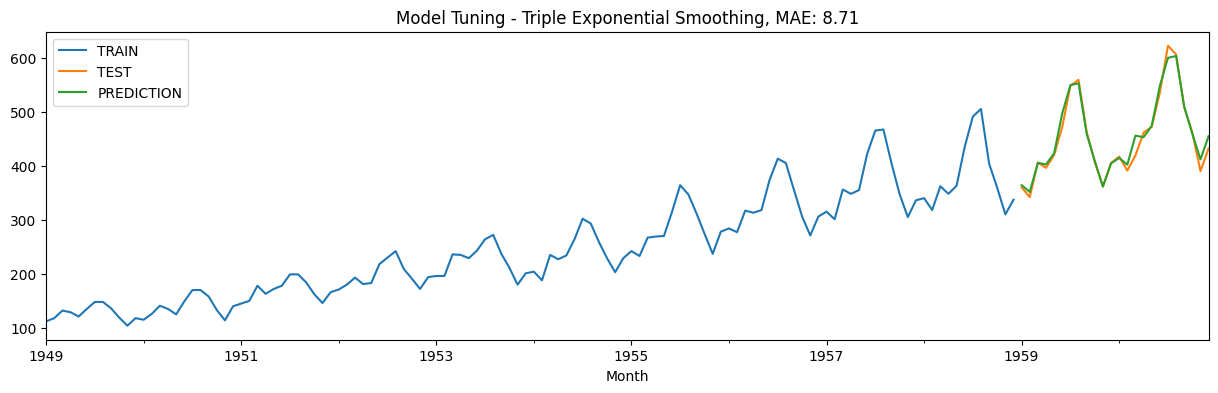

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=24, trend='add', seasonal='add', seasonal_periods=12)

# ARIMA: Autoregressive Integrated Moving Average

📌 In statistics and econometrics, and in particular in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. To better comprehend the data or forecast upcoming series points, both of these models are fitted to time series data. ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean.

In [ ]:
def arima_optimizer_mae(train, orders, step):
    best_mae, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_params = mae, order
        except:
            continue
    return best_mae, best_params

In [ ]:
def arima_model_tuning_mae(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
  p = d = q = range(0, 4)
  pdq = list(itertools.product(p, d, q))
  best_mae, best_params = arima_optimizer_mae(train, pdq, step)
  final_model = ARIMA(train, order=best_params).fit()
  y_pred = final_model.forecast(step)
  plot_model(train, test, y_pred, title)

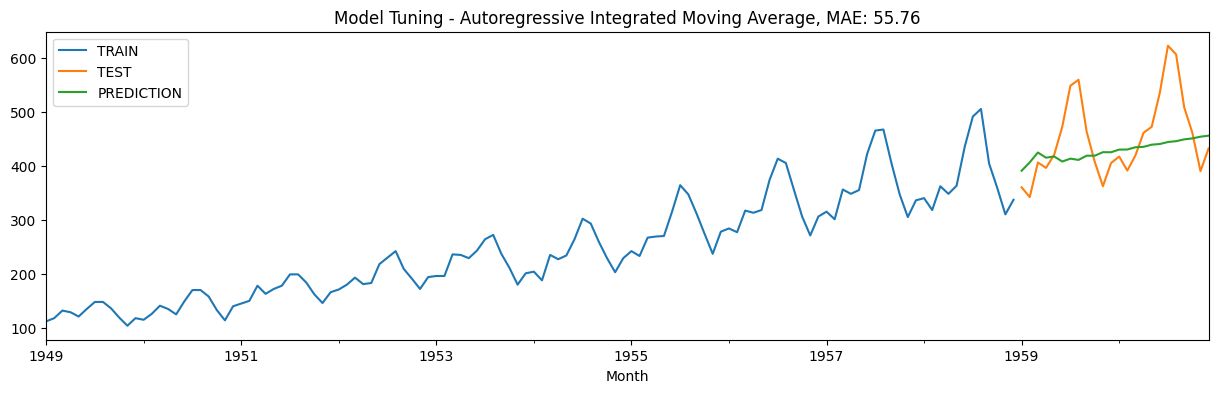

In [ ]:
arima_model_tuning_mae(train, test, step=24)

# SARIMA: Seasonal Autoregressive Integrated Moving-Average

📌 Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [ ]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq, step):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                y_pred_test = sarimax_model_results.get_forecast(step)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order

In [ ]:
def sarima_model_tuning_mae(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving-Average"):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq, step)
  final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order).fit()
  y_pred_test = final_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)
  return best_order, best_seasonal_order

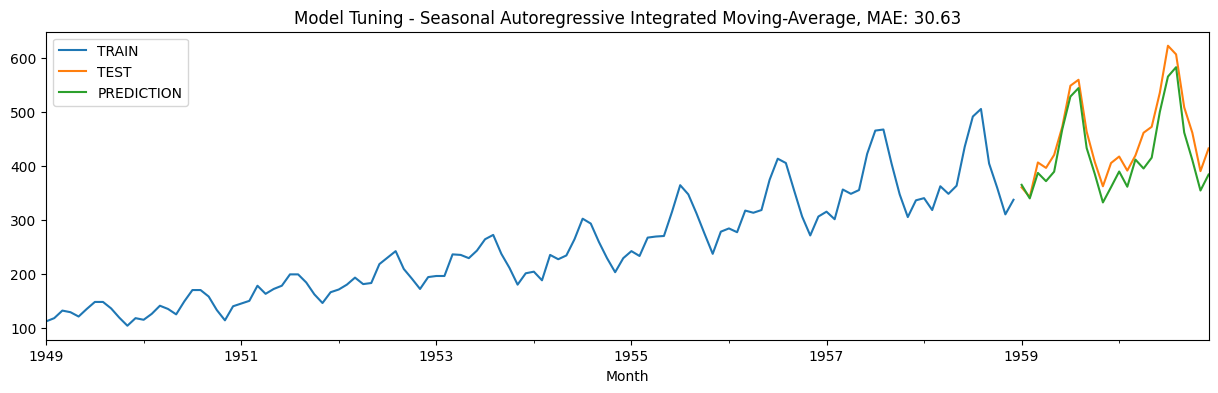

In [ ]:
best_order, best_seasonal_order = sarima_model_tuning_mae(train, test, step=24)

# Final Model(Prediction)

📌 When the MAE values of the methods are examined, it is observed that the TES model is more successful. Therefore, in this problem, we will make our estimations with the TES model.

**SES**: 82.53

**DES**: 54.1

### **TES**: **8.71**

**ARIMA**: 55.76

**SARIMA**: 30.63

In [ ]:
def tes_final_model(y, best_alpha, best_beta, best_gamma, step, trend='add', seasonal='add'):
  final_model = ExponentialSmoothing(y, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  feature_predict = final_model.forecast(step)
  return feature_predict

In [ ]:
tes_final_model(df, best_alpha, best_beta, best_gamma, step=6)

1961-01-01   447.0331
1961-02-01   419.9236
1961-03-01   458.6695
1961-04-01   485.4651
1961-05-01   497.3498
1961-06-01   556.8972
Freq: MS, dtype: float64